Processing: Pietersburg Plateau


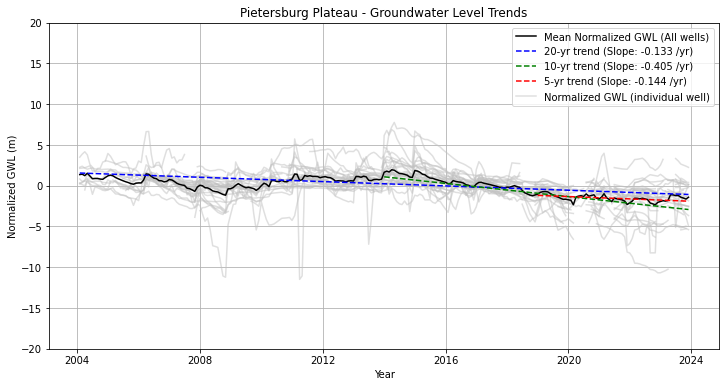

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, glob
from scipy.stats import theilslopes
from datetime import datetime
from tqdm import tqdm

# Define function to calculate trend
def calculate_sen_slope(df, years):
    """Calculate Theil-Sen slope for a given time period"""
    period = years * 12  # Convert years to months
    df_filtered = df.iloc[-period:]  # Get last `years` data
    
    y_values = df_filtered['norm_level']
    x_values = np.arange(len(y_values))  # Time as integers
    
    idx = np.isfinite(x_values) & np.isfinite(y_values)
    slope, intercept, _, _ = theilslopes(y_values[idx], x_values[idx])
    
    return slope, intercept, df_filtered

# Function to process hydrographs

def process_hydrographs(path, completeness=80, start='2004-01-01', end='2023-12-31'):
    list_aquifers = []
    start_date = datetime.strptime(start, '%Y-%m-%d')
    end_date = datetime.strptime(end, '%Y-%m-%d')
    
    for filename in glob.glob(os.path.join(path, '*.csv')):
        aquifer_name = os.path.splitext(os.path.basename(filename))[0]
        print(f"Processing: {aquifer_name}")
        
        # Load data
        df = pd.read_csv(filename)
        df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')
        df.set_index('date', inplace=True)
        df['level'] = df['level'].apply(lambda x: x * -1)  # Flip groundwater level
        
        df_pivot = df.pivot_table(index='date', columns='site', values='level')
        df_pivot = df_pivot.resample('1ME').mean()
        df_pivot = df_pivot.loc[start_date:end_date]
        
        # Filter based on completeness
        min_data_points = int(completeness / 100 * (len(df_pivot) / 12))
        accepted_wells = df_pivot.dropna(thresh=min_data_points, axis=1)
        
        if accepted_wells.empty:
            list_aquifers.append((aquifer_name, completeness, df_pivot.shape[1], 0, "Not enough data"))
            continue
        
        # Normalize levels
        df_melt = accepted_wells.stack().reset_index()
        df_melt.columns = ['date', 'site', 'level']
        df_melt.set_index('site', inplace=True)
        df_melt['mean_level'] = df_melt.groupby('site')['level'].transform('mean')
        df_melt['norm_level'] = df_melt['level'] - df_melt['mean_level']
        
        final_df = df_melt[['date', 'norm_level']].groupby('date').mean().reset_index()
        
        # Compute trends
        slopes = {}
        intercepts = {}
        filtered_dfs = {}
        for period in [20, 10, 5]:
            slopes[period], intercepts[period], filtered_dfs[period] = calculate_sen_slope(final_df, period)
        
        # Plot hydrograph
        fig, ax = plt.subplots(figsize=(12, 6))
        plt.plot(df_melt.pivot_table(index='date', columns='site', values='norm_level'), color='#C0C0C0', alpha=0.5)
        plt.plot(final_df['date'], final_df['norm_level'], color='black', label='Mean Normalized GWL (All wells)')
        
        # Trend lines only for the last 10 and 5 years, aligned with mean levels
        trend_10yr = slopes[10] * np.arange(len(filtered_dfs[10])) + intercepts[10]
        trend_5yr = slopes[5] * np.arange(len(filtered_dfs[5])) + intercepts[5]
        
        plt.plot(filtered_dfs[20]['date'], slopes[20] * np.arange(len(filtered_dfs[20])) + intercepts[20], 'b--', label=f'20-yr trend (Slope: {round(slopes[20] * 12, 3)} /yr)')
        plt.plot(filtered_dfs[10]['date'], trend_10yr, 'g--', label=f'10-yr trend (Slope: {round(slopes[10] * 12, 3)} /yr)')
        plt.plot(filtered_dfs[5]['date'], trend_5yr, 'r--', label=f'5-yr trend (Slope: {round(slopes[5] * 12, 3)} /yr)')
        
        plt.plot([], [], color='#C0C0C0', alpha=0.5, label='Normalized GWL (individual well)')
        
        ax.set_xlabel('Year')
        ax.set_ylabel('Normalized GWL (m)')
        plt.title(f"{aquifer_name} - Groundwater Level Trends")
        plt.legend()
        plt.grid(True)
        
        # Keep plot range fixed between +20 and -20
        plt.ylim([-20, 20])
        
        fig.savefig(os.path.join(path, f"{aquifer_name}_trends.pdf"), bbox_inches='tight')
        plt.show()
        
        # Store results
        list_aquifers.append((aquifer_name, completeness, df_pivot.shape[1], accepted_wells.shape[1], round(slopes[20] * 240, 3)))
    
    # Save summary CSV
    output_df = pd.DataFrame(list_aquifers, columns=['Aquifer', 'Threshold', 'Total Wells', 'Accepted Wells', '20-yr Slope'])
    output_df.to_csv(os.path.join(path, 'Hydrograph_Trends_Summary.csv'), index=False)

# Run function on your dataset
process_hydrographs("C:/Users/Alexandra/Desktop/Final product Trends and other indicators 2025/Simulations/South Africa/MK Results 5 10 20 years/Pietersburg Plateau/Hydrographs/")
